In [1]:
import os
from pathlib import Path
from typing import Optional

import fastmri
import h5py
import matplotlib.pyplot as plt
import numpy as np
import torch
from data_utils import *
from datasets import *
from fastmri.data.transforms import tensor_to_complex_np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from torch.utils.data import DataLoader, TensorDataset

from model import *
from torch.optim import SGD, Adam, AdamW
from train_utils import *

In [2]:
model_checkpoint = '/scratch_net/ken/mcrespo/proj_marina/logs/multivol/2024-11-13_12h31m52s/checkpoints/epoch_0999.pt'  # TODO: SET (OR LEAVE COMMENTED).
path_to_data = '/itet-stor/mcrespo/bmicdatasets-originals/Originals/fastMRI/brain/multicoil_train/'


In [7]:
n_volumes = 1
n_slices = 3
with_mask  = False
acceleration = 4
center_frac  = 0.15

path_to_data = Path(path_to_data)
if path_to_data.is_dir():
    files = sorted(
        [
            file
            for file in path_to_data.iterdir()
            if file.suffix == ".h5" and "AXT1POST_205" in file.name
        ]
    )[:n_volumes]
else:
    files = [path_to_data]

# For each MRI volume in the dataset...
for vol_id, file in enumerate(files):
    # Load MRI volume
    with h5py.File(file, "r") as hf:
        volume_kspace = to_tensor(preprocess_kspace(hf["kspace"][()]))[
            :n_slices
        ]

    ##################################################
    # Mask creation
    ##################################################
    mask_func = EquiSpacedMaskFunc(
        center_fractions=[center_frac], accelerations=[acceleration]
    )
    shape = (1,) * len(volume_kspace.shape[:-3]) + tuple(
        volume_kspace.shape[-3:]
    )
    mask, _ = mask_func(
        shape, None, vol_id
    )  # use the volume index as random seed.

    mask, left_idx, right_idx = remove_center(mask)
    # _, left_idx, right_idx = remove_center(mask)  # NOTE: Uncomment to include the center region in the training data. Note that 'left_idx' and 'right_idx' are still needed.

    ##################################################
    # Computing the indices
    ##################################################
    n_slices, n_coils, height, width = volume_kspace.shape[:-1]
    if with_mask:
        kx_ids = torch.where(mask.squeeze())[0]
    else:
        kx_ids = torch.arange(width)
        # kx_ids = torch.from_numpy(np.setdiff1d(np.arange(width), np.arange(left_idx, right_idx))) # NOTE: Uncomment to include all the datapoints (fully-sampled volume), with the exception of the center region.

    ky_ids = torch.arange(height)
    kz_ids = torch.arange(n_slices)
    coil_ids = torch.arange(n_coils)

    kspace_ids = torch.meshgrid(kx_ids, ky_ids, kz_ids, coil_ids, indexing="ij")
    kspace_ids = torch.stack(kspace_ids, dim=-1).reshape(-1, len(kspace_ids))

    ##################################################
    # Computing the inputs
    ##################################################
    # Convert indices into normalized coordinates in [-1, 1].
    kspace_coords = torch.zeros((kspace_ids.shape[0], 4), dtype=torch.float)
    kspace_coords[:, :2] = kspace_ids[:, :2]
    kspace_coords[:, 2] = (2 * kspace_ids[:, 2]) / (n_slices - 1) - 1
    kspace_coords[:, 3] = (2 * kspace_ids[:, 3]) / (n_coils - 1) - 1

    # Used to determine the latent vector (one per volume).
    vol_ids = torch.tensor([vol_id] * len(kspace_coords)).unsqueeze(1)


    ##################################################
    # Computing the targets
    ##################################################
    targets = volume_kspace[
        kspace_ids[:, 2], kspace_ids[:, 3], kspace_ids[:, 1], kspace_ids[:, 0]
    ]


In [14]:
mask = (kspace_ids[:, 0] > left_idx) & (kspace_ids[:, 0] < right_idx)
center = kspace_ids[mask]
edges = kspace_ids[~mask]

In [25]:

new_kspace = torch.zeros(volume_kspace.shape, dtype=torch.double)
# new_kspace[center[:,2], center[:,3], center[:,1], center[:,0]] = volume_kspace[center[:,2], center[:,3], center[:,1], center[:,0]]

new_kspace[edges[:,2], edges[:,3], edges[:,1], edges[:,0]] = volume_kspace[edges[:,2], edges[:,3], edges[:,1], edges[:,0]]

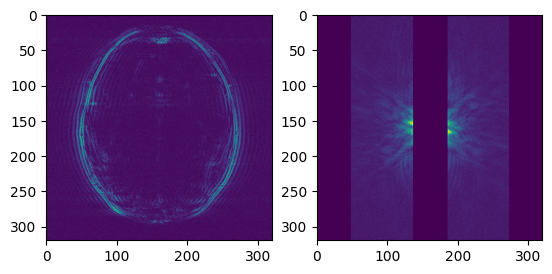

In [26]:
new_img = rss(inverse_fft2_shift(torch.view_as_complex(new_kspace)))
mykspace = rss(torch.view_as_complex(new_kspace))

plt.figure()
plt.subplot(1,2,1)
plt.imshow(np.abs(new_img[0]))
plt.subplot(1,2,2)
plt.imshow(np.abs(mykspace[0]))